# DVD Rental Duration Prediction Model

![dvd_image](dvd_image.jpg)

## Project Overview

A DVD rental company requires predictive modeling assistance to optimize their inventory planning. They need a machine learning solution to predict the number of days a customer will rent a DVD based on available features.

**Business Objective:** Develop a regression model that achieves a Mean Squared Error (MSE) ≤ 3.0 on the test set.

## Dataset Description

The provided dataset (`rental_info.csv`) contains the following features:

### Date/Time Features
- **`rental_date`**: The date and time when the customer rents the DVD
- **`return_date`**: The date and time when the customer returns the DVD

### Financial Features  
- **`amount`**: The amount paid by the customer for renting the DVD
- **`amount_2`**: The square of the amount
- **`rental_rate`**: The rate at which the DVD is rented
- **`rental_rate_2`**: The square of the rental rate
- **`replacement_cost`**: The cost to replace the DVD

### Movie Features
- **`release_year`**: The year the movie was released
- **`length`**: Length of the movie in minutes  
- **`length_2`**: The square of the movie length
- **`special_features`**: Special features included (trailers, deleted scenes, etc.)

### Rating Features (Dummy Variables)
- **`NC-17`**, **`PG`**, **`PG-13`**, **`R`**: Binary indicators for movie ratings (reference category already dropped)

---

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Regression models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2
TARGET_MSE = 3.0

# Load dataset
print("Loading dataset...")
data = pd.read_csv('rental_info.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {data.shape}")
data.head()

Loading dataset...
Dataset loaded successfully!
Dataset shape: (15861, 15)


,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


# 1. Exploratory Data Analysis

In this section, we examine the structure, quality, and characteristics of our dataset to understand the data we're working with.

In [2]:
# Dataset overview
print("=" * 50)
print("DATASET INFORMATION")
print("=" * 50)
data.info()

print("\n" + "=" * 50)
print("DATASET STATISTICAL SUMMARY")
print("=" * 50)
data.describe()

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB

DATASET S

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,4.217161,2006.885379,2.944101,114.994578,20.224727,0.204842,0.200303,0.223378,0.198726,23.355504,14832.841876,11.389287
std,2.360383,2.025027,1.649766,40.114715,6.083784,0.403599,0.400239,0.416523,0.399054,23.503164,9393.431996,10.005293
min,0.990000,2004.000000,0.990000,46.000000,9.990000,0.000000,0.000000,0.000000,0.000000,0.980100,2116.000000,0.980100
25%,2.990000,2005.000000,0.990000,81.000000,14.990000,0.000000,0.000000,0.000000,0.000000,8.940100,6561.000000,0.980100
50%,3.990000,2007.000000,2.990000,114.000000,20.990000,0.000000,0.000000,0.000000,0.000000,15.920100,12996.000000,8.940100
75%,4.990000,2009.000000,4.990000,148.000000,25.990000,0.000000,0.000000,0.000000,0.000000,24.900100,21904.000000,24.900100
max,11.990000,2010.000000,4.990000,185.000000,29.990000,1.000000,1.000000,1.000000,1.000000,143.760100,34225.000000,24.900100


In [3]:
# Explore special features column
print("=" * 50)
print("SPECIAL FEATURES ANALYSIS")
print("=" * 50)
print("Special Features Distribution:")
print(data["special_features"].value_counts())
print(f"\nUnique special features count: {data['special_features'].nunique()}")

SPECIAL FEATURES ANALYSIS
Special Features Distribution:
special_features
{Trailers,Commentaries,"Behind the Scenes"}                     1308
{Trailers}                                                      1139
{Trailers,Commentaries}                                         1129
{Trailers,"Behind the Scenes"}                                  1122
{"Behind the Scenes"}                                           1108
{Commentaries,"Deleted Scenes","Behind the Scenes"}             1101
{Commentaries}                                                  1089
{Commentaries,"Behind the Scenes"}                              1078
{Trailers,"Deleted Scenes"}                                     1047
{"Deleted Scenes","Behind the Scenes"}                          1035
{"Deleted Scenes"}                                              1023
{Commentaries,"Deleted Scenes"}                                 1011
{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}     983
{Trailers,Commentaries,"Delet

# 2. Data Preprocessing & Feature Engineering

This section focuses on preparing the data for machine learning by creating the target variable, engineering new features, and handling categorical variables.

In [4]:
"""
Data Preprocessing Pipeline
"""

print("=" * 50)
print("DATA PREPROCESSING")
print("=" * 50)

# Create target variable: rental length in days
print("1. Creating target variable...")
data["rental_length_days"] = (
    pd.to_datetime(data["return_date"]) - pd.to_datetime(data["rental_date"])
).dt.days

# Create dummy variables for special_features column
print("2. Creating feature engineering variables...")
special_features_dummies = pd.DataFrame({
    "deleted_scenes": data["special_features"].apply(
        lambda x: 1 if "Deleted Scenes" in str(x) else 0
    ),
    "behind_the_scenes": data["special_features"].apply(
        lambda x: 1 if "Behind the Scenes" in str(x) else 0
    ),
    "commentaries": data["special_features"].apply(
        lambda x: 1 if "Commentaries" in str(x) else 0
    ),
    "trailers": data["special_features"].apply(
        lambda x: 1 if "Trailers" in str(x) else 0
    ),
})

# Add derived features
data = pd.concat([data, special_features_dummies], axis=1)
data["n_features"] = special_features_dummies.sum(axis=1)
data["is_weekend"] = pd.to_datetime(data["rental_date"]).dt.dayofweek >= 5
data["movie_age"] = (
    pd.to_datetime(data["rental_date"]).dt.year - 
    pd.to_datetime(data["release_year"]).dt.year
)

print("3. Preprocessing completed successfully!")
print(f"Original dataset shape: {data.shape}")
print(f"\nTarget variable (rental_length_days) statistics:")
print(data["rental_length_days"].describe())

# Display updated dataset
data.head()

DATA PREPROCESSING
1. Creating target variable...
2. Creating feature engineering variables...
3. Preprocessing completed successfully!
Original dataset shape: (15861, 23)

Target variable (rental_length_days) statistics:
count    15861.000000
mean         4.525944
std          2.635108
min          0.000000
25%          2.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: rental_length_days, dtype: float64
3. Preprocessing completed successfully!
Original dataset shape: (15861, 23)

Target variable (rental_length_days) statistics:
count    15861.000000
mean         4.525944
std          2.635108
min          0.000000
25%          2.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: rental_length_days, dtype: float64


,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,...,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes,commentaries,trailers,n_features,is_weekend,movie_age
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,...,15876.0,8.9401,3,0,1,0,1,2,False,35
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,...,15876.0,8.9401,2,0,1,0,1,2,False,35
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,...,15876.0,8.9401,7,0,1,0,1,2,True,35
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,...,15876.0,8.9401,2,0,1,0,1,2,True,35
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,...,15876.0,8.9401,4,0,1,0,1,2,False,35


# 3. Machine Learning Model Development

## 3.1 Data Preparation & Utility Functions

This section establishes our modeling framework, including train-test split, feature scaling, and evaluation functions.

In [5]:
"""
Model Training and Evaluation Functions
"""

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Train a model and return its RMSE on test set.
    
    Parameters:
    -----------
    model : sklearn estimator
        The machine learning model to train
    X_train, y_train : array-like
        Training features and target
    X_test, y_test : array-like
        Test features and target
        
    Returns:
    --------
    float : RMSE score on test set
    """
    model.fit(X_train, y_train)
    return evaluate_model(model, X_test, y_test)


def evaluate_model(model, X_test, y_test):
    """
    Evaluate model and return RMSE.
    
    Parameters:
    -----------
    model : trained sklearn estimator
        The trained model to evaluate
    X_test, y_test : array-like
        Test features and target
        
    Returns:
    --------
    float : RMSE score
    """
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse


print("=" * 50)
print("DATA PREPARATION")
print("=" * 50)

# Prepare features and target
y = data["rental_length_days"]
feature_columns = [col for col in data.columns if col not in 
                  ["rental_length_days", "rental_date", "return_date", "special_features"]]
X = data[feature_columns]

print(f"Features selected: {len(feature_columns)}")
print(f"Target variable: rental_length_days")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Standardize features for models that require it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display dataset split information
print(f"\nDataset split (test_size={TEST_SIZE}):")
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Target variable standard deviation: {np.std(y_train):.2f}")

DATA PREPARATION
Features selected: 19
Target variable: rental_length_days

Dataset split (test_size=0.2):
Training set size: (12688, 19)
Test set size: (3173, 19)
Target variable standard deviation: 2.64

Dataset split (test_size=0.2):
Training set size: (12688, 19)
Test set size: (3173, 19)
Target variable standard deviation: 2.64


# 3.2 Baseline Model Evaluation

We begin by training and evaluating several baseline regression models to establish performance benchmarks.

In [6]:
"""
Baseline Model Training and Evaluation
"""

print("=" * 60)
print("BASELINE MODEL EVALUATION")
print("=" * 60)

# Define baseline models
baseline_models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(random_state=RANDOM_STATE),
    'Ridge Regression': Ridge(random_state=RANDOM_STATE),
    'Random Forest': RandomForestRegressor(random_state=RANDOM_STATE),
    'SVR': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

# Models that require scaled features
models_requiring_scaling = ['Lasso Regression', 'Ridge Regression', 'SVR', 'K-Nearest Neighbors']

baseline_results = {}
print("Training baseline models...")
print("-" * 60)

for name, model in baseline_models.items():
    print(f"Training {name}...")
    
    # Use scaled features for models that require it
    if name in models_requiring_scaling:
        rmse = train_and_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    else:
        rmse = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    
    baseline_results[name] = {'RMSE': rmse, 'MSE': rmse**2}
    mse_status = "✅" if rmse**2 < TARGET_MSE else "❌"
    print(f"{name:<25}: RMSE={rmse:.4f}, MSE={rmse**2:.4f} {mse_status}")

# Find best baseline model
best_baseline = min(baseline_results.items(), key=lambda x: x[1]['RMSE'])
print(f"\n🏆 Best baseline model: {best_baseline[0]}")
print(f"   RMSE: {best_baseline[1]['RMSE']:.4f}")
print(f"   MSE:  {best_baseline[1]['MSE']:.4f}")

BASELINE MODEL EVALUATION
Training baseline models...
------------------------------------------------------------
Training Linear Regression...
Linear Regression        : RMSE=1.7072, MSE=2.9146 ✅
Training Lasso Regression...
Lasso Regression         : RMSE=2.4032, MSE=5.7751 ❌
Training Ridge Regression...
Ridge Regression         : RMSE=1.7072, MSE=2.9147 ✅
Training Random Forest...
Lasso Regression         : RMSE=2.4032, MSE=5.7751 ❌
Training Ridge Regression...
Ridge Regression         : RMSE=1.7072, MSE=2.9147 ✅
Training Random Forest...
Random Forest            : RMSE=1.4398, MSE=2.0730 ✅
Training SVR...
Random Forest            : RMSE=1.4398, MSE=2.0730 ✅
Training SVR...
SVR                      : RMSE=1.5476, MSE=2.3952 ✅
Training K-Nearest Neighbors...
SVR                      : RMSE=1.5476, MSE=2.3952 ✅
Training K-Nearest Neighbors...
K-Nearest Neighbors      : RMSE=1.9587, MSE=3.8366 ❌

🏆 Best baseline model: Random Forest
   RMSE: 1.4398
   MSE:  2.0730
K-Nearest Neighbors 

# 3.3 Hyperparameter Optimization

To improve model performance, we perform grid search optimization on the most promising algorithms identified in the baseline evaluation.

In [7]:
"""
Gradient Boosting Hyperparameter Optimization
"""

print("=" * 60)
print("GRADIENT BOOSTING HYPERPARAMETER TUNING")
print("=" * 60)

# Define parameter grid for Gradient Boosting
gb_param_grid = {
    "n_estimators": [400, 450, 500],
    "max_depth": [4, 5, 6],
    "subsample": [0.5, 0.55, 0.6],
    "max_features": [0.5, 0.55, 0.6]
}

print("Parameter grid:")
for param, values in gb_param_grid.items():
    print(f"  {param}: {values}")

print(f"\nTotal combinations: {np.prod([len(v) for v in gb_param_grid.values()])}")
print("Starting grid search with 5-fold cross-validation...")

# Perform grid search
gb_grid = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=RANDOM_STATE),
    param_grid=gb_param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train, y_train)

# Results
gb_best_rmse = np.sqrt(-gb_grid.best_score_)
print(f"\n✅ Gradient Boosting optimization completed!")
print(f"Best parameters: {gb_grid.best_params_}")
print(f"Best cross-validated RMSE: {gb_best_rmse:.4f}")

GRADIENT BOOSTING HYPERPARAMETER TUNING
Parameter grid:
  n_estimators: [400, 450, 500]
  max_depth: [4, 5, 6]
  subsample: [0.5, 0.55, 0.6]
  max_features: [0.5, 0.55, 0.6]

Total combinations: 81
Starting grid search with 5-fold cross-validation...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

✅ Gradient Boosting optimization completed!
Best parameters: {'max_depth': 5, 'max_features': 0.6, 'n_estimators': 500, 'subsample': 0.6}
Best cross-validated RMSE: 1.3844

✅ Gradient Boosting optimization completed!
Best parameters: {'max_depth': 5, 'max_features': 0.6, 'n_estimators': 500, 'subsample': 0.6}
Best cross-validated RMSE: 1.3844


# 3.4 Ensemble Model Development

We combine the best-performing individual models using ensemble techniques to potentially achieve better predictive performance.

In [8]:
"""
Random Forest Hyperparameter Optimization
"""

print("=" * 60)
print("RANDOM FOREST HYPERPARAMETER TUNING")
print("=" * 60)

# Define parameter grid for Random Forest
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

print("Parameter grid:")
for param, values in rf_param_grid.items():
    print(f"  {param}: {values}")

print(f"\nTotal combinations: {np.prod([len(v) for v in rf_param_grid.values()])}")
print("Starting grid search with 5-fold cross-validation...")

# Perform grid search
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=RANDOM_STATE),
    param_grid=rf_param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

# Results
rf_best_rmse = np.sqrt(-rf_grid.best_score_)
print(f"\n✅ Random Forest optimization completed!")
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best cross-validated RMSE: {rf_best_rmse:.4f}")

RANDOM FOREST HYPERPARAMETER TUNING
Parameter grid:
  n_estimators: [100, 200, 300]
  max_depth: [10, 20]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2']

Total combinations: 108
Starting grid search with 5-fold cross-validation...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Random Forest optimization completed!
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validated RMSE: 1.4484

✅ Random Forest optimization completed!
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validated RMSE: 1.4484


In [9]:
"""
Ensemble Model: Voting Regressor
"""

print("=" * 60)
print("VOTING REGRESSOR ENSEMBLE")
print("=" * 60)

# Create voting regressor with optimized models
print("Creating Voting Regressor with best Random Forest and Gradient Boosting models...")

voting_regressor = VotingRegressor(
    estimators=[
        ("random_forest", rf_grid.best_estimator_),
        ("gradient_boosting", gb_grid.best_estimator_)
    ]
)

# Train and evaluate the voting regressor
voting_test_rmse = train_and_evaluate_model(
    voting_regressor, X_train, y_train, X_test, y_test
)

print(f"✅ Voting Regressor Results:")
print(f"   Test RMSE: {voting_test_rmse:.4f}")

rmse_status = "✅ MEETS TARGET" if voting_test_rmse**2 < TARGET_MSE else "❌ ABOVE TARGET"
print(f"   Status: {rmse_status} (Target MSE < {TARGET_MSE})")

VOTING REGRESSOR ENSEMBLE
Creating Voting Regressor with best Random Forest and Gradient Boosting models...
✅ Voting Regressor Results:
   Test RMSE: 1.3734
   Status: ✅ MEETS TARGET (Target MSE < 3.0)
✅ Voting Regressor Results:
   Test RMSE: 1.3734
   Status: ✅ MEETS TARGET (Target MSE < 3.0)


# 4. Results Analysis & Model Performance

This section provides a comprehensive evaluation of all developed models and determines the best solution for the business problem.

In [10]:
"""
Final Model Performance Summary
"""

print("=" * 70)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("=" * 70)
print(f"🎯 Target: MSE < {TARGET_MSE}")
print("-" * 70)

# Evaluate all optimized models on test set
final_models = {
    'Random Forest (Optimized)': rf_grid.best_estimator_,
    'Gradient Boosting (Optimized)': gb_grid.best_estimator_,
    'Voting Regressor (Ensemble)': voting_regressor
}

final_results = {}

print("Evaluating optimized models on test set...")
print("-" * 70)

for model_name, model in final_models.items():
    test_rmse = evaluate_model(model, X_test, y_test)
    test_mse = test_rmse ** 2
    
    final_results[model_name] = {
        'model': model,
        'rmse': test_rmse,
        'mse': test_mse
    }

    status = "✅ MEETS TARGET" if test_rmse < TARGET_MSE else "❌ ABOVE TARGET"
    print(f"{model_name:<30}: RMSE={test_rmse:.4f}, MSE={test_mse:.4f} {status}")

# Determine best model
best_model_name = min(final_results.keys(), key=lambda x: final_results[x]['rmse'])
best_model_info = final_results[best_model_name]

print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"   Final Test RMSE: {best_model_info['rmse']:.4f}")
print(f"   Final Test MSE:  {best_model_info['mse']:.4f}")

if best_model_info['rmse'] < TARGET_MSE:
    print(f"✅ SUCCESS: Model meets the company's RMSE < {TARGET_MSE} requirement!")
else:
    print(f"❌ Target not met - further optimization needed.")
    
print("=" * 70)

FINAL MODEL PERFORMANCE SUMMARY
🎯 Target: MSE < 3.0
----------------------------------------------------------------------
Evaluating optimized models on test set...
----------------------------------------------------------------------
Random Forest (Optimized)     : RMSE=1.4168, MSE=2.0072 ✅ MEETS TARGET
Gradient Boosting (Optimized) : RMSE=1.3548, MSE=1.8354 ✅ MEETS TARGET
Voting Regressor (Ensemble)   : RMSE=1.3734, MSE=1.8864 ✅ MEETS TARGET

🏆 BEST PERFORMING MODEL: Gradient Boosting (Optimized)
   Final Test RMSE: 1.3548
   Final Test MSE:  1.8354
✅ SUCCESS: Model meets the company's RMSE < 3.0 requirement!
Voting Regressor (Ensemble)   : RMSE=1.3734, MSE=1.8864 ✅ MEETS TARGET

🏆 BEST PERFORMING MODEL: Gradient Boosting (Optimized)
   Final Test RMSE: 1.3548
   Final Test MSE:  1.8354
✅ SUCCESS: Model meets the company's RMSE < 3.0 requirement!


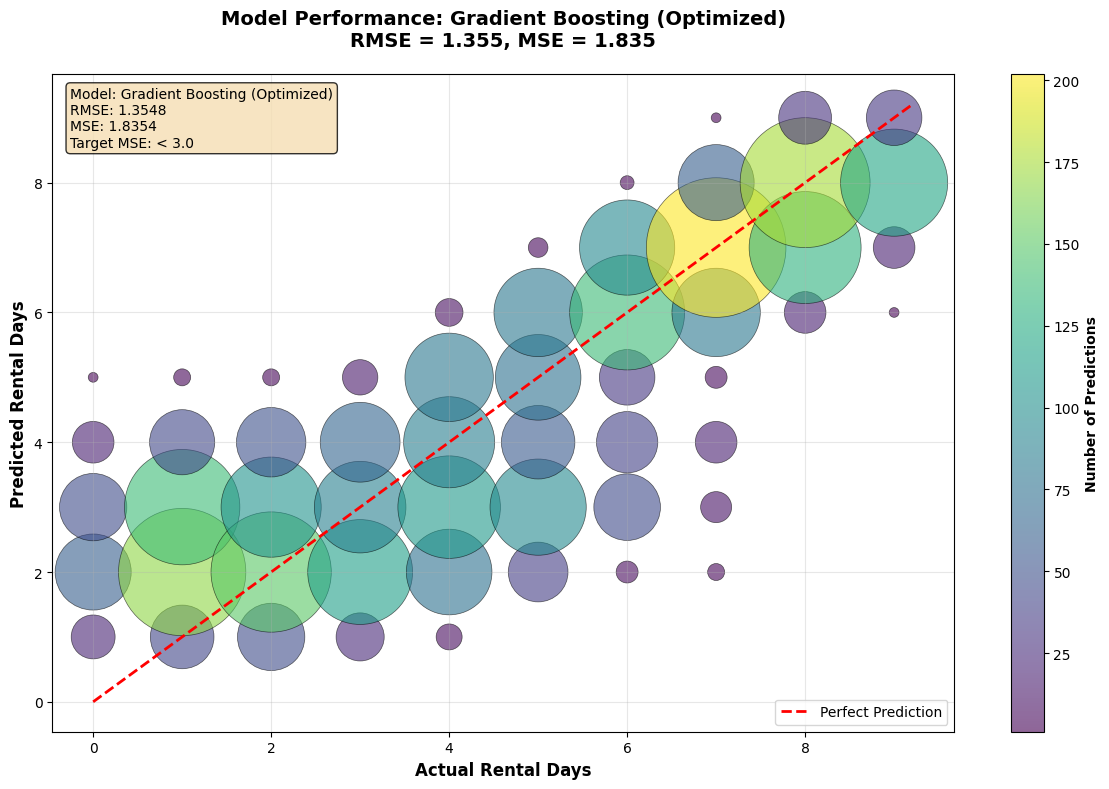


Prediction Summary:
Mean Absolute Error: 1.055 days
Standard Deviation of Residuals: 1.355 days
R² Score: 0.7328


In [11]:
"""
Model Performance Visualization
"""

# Get predictions from the best model
best_model = final_results[best_model_name]['model']
y_pred_best = best_model.predict(X_test)

# Prepare data for visualization
predictions_df = pd.DataFrame({
    'Actual': np.round(y_test).astype(int),
    'Predicted': np.round(y_pred_best).astype(int)
})

# Aggregate data points by actual vs predicted values for better visualization
size_df = predictions_df.groupby(['Actual', 'Predicted']).size().reset_index(name='count')

# Create the visualization
plt.figure(figsize=(12, 8))
plt.style.use('default')

# Create scatter plot with bubble sizes representing frequency
scatter = plt.scatter(
    size_df['Actual'],
    size_df['Predicted'],
    s=size_df['count'] * 50,  # Scale bubble sizes
    alpha=0.6,
    c=size_df['count'],
    cmap='viridis',
    edgecolors='black',
    linewidth=0.5
)

# Add perfect prediction line
min_val = min(min(y_test), min(y_pred_best))
max_val = max(max(y_test), max(y_pred_best))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

# Customize the plot
plt.xlabel('Actual Rental Days', fontsize=12, fontweight='bold')
plt.ylabel('Predicted Rental Days', fontsize=12, fontweight='bold')
plt.title(f'Model Performance: {best_model_name}\nRMSE = {best_model_info["rmse"]:.3f}, MSE = {best_model_info["mse"]:.3f}', 
          fontsize=14, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Number of Predictions', fontsize=10, fontweight='bold')

# Add legend and grid
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Make the plot look more professional
plt.tight_layout()

# Add text box with model performance
textstr = f'Model: {best_model_name}\nRMSE: {best_model_info["rmse"]:.4f}\nMSE: {best_model_info["mse"]:.4f}\nTarget MSE: < {TARGET_MSE}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.show()

# Print summary statistics
print("\nPrediction Summary:")
print(f"Mean Absolute Error: {np.mean(np.abs(y_test - y_pred_best)):.3f} days")
print(f"Standard Deviation of Residuals: {np.std(y_test - y_pred_best):.3f} days")
print(f"R² Score: {best_model.score(X_test, y_test):.4f}")